# 04 - Applied ML

In [1]:
# import all the required libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

## Cleaning the data

In [2]:
# import the data
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

# save initial number of records
initial_records = df.shape[0]

# initial shape of the data
print('Initial shape of the DataFrame:', df.shape)

Initial shape of the DataFrame: (146028, 28)


In [3]:
# check which columns have NaNs
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID           True
rater1            True
rater2            True
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

We can drop the column photoID since we won't use the photos of the players.

In [4]:
df = df.drop(['photoID'], axis=1)

In [5]:
# remove records that have rater1 and/or rater2 as NaNs
df = df.dropna(axis=0, subset=['rater1', 'rater2'])

# create a new column with the mean of the two raters
# df['raterMean'] = (df['rater1'] + df['rater2']) / 2
df['raterMean'] = (df['rater1'] * df['rater2']) ** 0.5

# remove the columns rater1 and rater2
df = df.drop(['rater1', 'rater2'], axis=1)

In [6]:
df.shape

(124621, 26)

Let's now focus on the referees. As stated in [this notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb), we should only take into account referees that took part in games of one of the considered leagues. This means that referees with less than 22 dyads (corresponding to the, at least, 22 players of a game) shouldn't be relevant.

In [7]:
refs = df['refNum'].value_counts()

df = df[df['refNum'].isin(refs[refs > 21].index)]

In [8]:
df.shape

(112484, 26)

Since we will group the records by player, the columns concerning the referees information can be removed, namely: refNum, refCountry and Alpha_3.

In [9]:
df = df.drop(['refNum', 'refCountry', 'Alpha_3'], axis=1)

Let's check again the features that have NaNs associated.

In [10]:
# check which columns have NaNs
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
raterMean        False
dtype: bool

In [11]:
df = df.dropna(axis=0, subset=['height', 'weight'])

records_after = df.shape[0]

By dropping the records that have NaNs in the height and weight columns we loose the following percentage of data:

In [12]:
(initial_records - records_after) / initial_records * 100

23.376338784342728

The columns nIAT, seIAT, nExp and seExp are associated with a particular referee and this information will become irrelevant as soon as the data is aggregated by players. So we'll also remove these features.

In [13]:
df.drop(['nIAT', 'seIAT', 'nExp', 'seExp'], axis=1, inplace=True)

We can remove the columns that have non-numeric data associated (the ones we believe are irrelevant for the problem):

In [14]:
non_numeric_features = ['player', 'club', 'birthday']
df.drop(non_numeric_features, axis=1, inplace=True)

In [15]:
df.isnull().any()

playerShort      False
leagueCountry    False
height           False
weight           False
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
meanIAT           True
meanExp           True
raterMean        False
dtype: bool

In [16]:
df = df.dropna(axis=0, subset=['meanIAT', 'meanExp'])

In [17]:
print('Shape of the DataFrame before aggregating by player:', df.shape)

Shape of the DataFrame before aggregating by player: (111782, 16)


## Aggregating the data (by player)

In [18]:
grouped_by_player = df.groupby(['playerShort', 'height', 'weight', 'raterMean', 'leagueCountry', 'position'], as_index=False)

clean_data = grouped_by_player.agg({'games': np.sum, 'victories': np.sum, 'ties': np.sum, 'defeats': np.sum, 'goals': np.sum,
                       'yellowCards': np.sum, 'yellowReds': np.sum, 'redCards': np.sum, 'meanIAT': np.mean, 'meanExp': np.mean})

# drop the column playerShort (non-numeric data not relevant for the classifier)
clean_data.drop('playerShort', axis=1, inplace=True)

In [19]:
clean_data = pd.get_dummies(clean_data, prefix = ['dummyCode_','dummyCode_'])

## Training the Classifier

In [20]:
def labels_categories(y):
    if(y['raterMean'] <= 0.2):
        return 0
    elif(y['raterMean'] <= 0.4):
        return 1
    elif(y['raterMean'] <= 0.6):
        return 2
    elif(y['raterMean'] <= 0.8):
        return 3
    else:
        return 4

In [21]:
clean_data['skin_cat'] = clean_data.apply(labels_categories, axis=1)

X = clean_data.drop(['skin_cat', 'raterMean'], axis=1)

Y = np.asarray(clean_data['skin_cat'], dtype="|S6")

X.columns

Index(['height', 'weight', 'defeats', 'meanIAT', 'yellowCards', 'games',
       'redCards', 'ties', 'yellowReds', 'victories', 'meanExp', 'goals',
       'dummyCode__England', 'dummyCode__France', 'dummyCode__Germany',
       'dummyCode__Spain', 'dummyCode__Attacking Midfielder',
       'dummyCode__Center Back', 'dummyCode__Center Forward',
       'dummyCode__Center Midfielder', 'dummyCode__Defensive Midfielder',
       'dummyCode__Goalkeeper', 'dummyCode__Left Fullback',
       'dummyCode__Left Midfielder', 'dummyCode__Left Winger',
       'dummyCode__Right Fullback', 'dummyCode__Right Midfielder',
       'dummyCode__Right Winger'],
      dtype='object')

### Selecting the Classifier Parameters

In [22]:
from sklearn.cross_validation import KFold

number_splits = 10
kf = KFold(X.shape[0], n_folds=number_splits)

train_errors =[]
test_errors = []
number_estimators = range(1, 50)

for nb_est in number_estimators:
    mean_train_error = 0.0
    mean_test_error = 0.0
    
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf = RandomForestClassifier(n_estimators=nb_est, criterion='entropy')
        clf = clf.fit(X_train, Y_train)
        
        train_error = 1.0 - clf.score(X_train, Y_train)
        test_error = 1.0 - clf.score(X_test, Y_test)
        
        mean_train_error += train_error
        mean_test_error += test_error
        
    train_errors.append(mean_train_error/number_splits)
    test_errors.append(mean_test_error/number_splits)

/Users/Sym/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


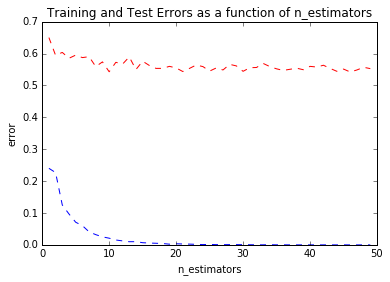

In [23]:
plt.plot(number_estimators, test_errors, 'r--', number_estimators, train_errors, 'b--')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('Training and Test Errors as a function of n_estimators')
plt.show()

In [24]:
train_errors = []
test_errors = []
max_depths = range(1, 20)

for depth in max_depths:
    mean_train_error = 0.0
    mean_test_error = 0.0
    
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=depth)
        clf = clf.fit(X_train, Y_train)
        
        train_error = 1.0 - clf.score(X_train, Y_train)
        test_error = 1.0 - clf.score(X_test, Y_test)
        
        mean_train_error += train_error
        mean_test_error += test_error
        
    train_errors.append(mean_train_error/number_splits)
    test_errors.append(mean_test_error/number_splits)

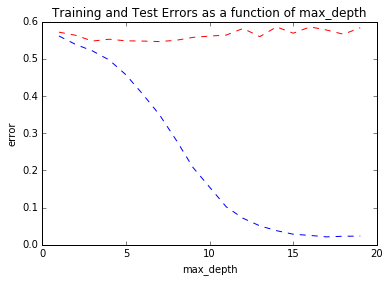

In [25]:
plt.plot(max_depths, test_errors, 'r--', max_depths, train_errors, 'b--')
plt.xlabel('max_depth')
plt.ylabel('error')
plt.title('Training and Test Errors as a function of max_depth')
plt.show()

### Best parameter selection :

According to the graphe to avoid overfitting we take max_depth = 15 and n_estimator = 10

### Analising feature importances

In [31]:
# build a random forest and compute the feature importances
optimal_n_estimators = 10
optimal_max_depth = 15

clf = RandomForestClassifier(n_estimators=optimal_n_estimators, criterion='entropy', max_depth=optimal_max_depth)
clf = clf.fit(X, Y)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 10 (0.107623)
2. feature 3 (0.095337)
3. feature 5 (0.082461)
4. feature 2 (0.079418)
5. feature 11 (0.079199)
6. feature 4 (0.073940)
7. feature 7 (0.073810)
8. feature 9 (0.071454)
9. feature 0 (0.070548)
10. feature 1 (0.068615)
11. feature 6 (0.036419)
12. feature 8 (0.030606)
13. feature 13 (0.018582)
14. feature 14 (0.016699)
15. feature 18 (0.011640)
16. feature 17 (0.011196)
17. feature 12 (0.009611)
18. feature 20 (0.009426)
19. feature 21 (0.007228)
20. feature 15 (0.007148)
21. feature 25 (0.006714)
22. feature 16 (0.006221)
23. feature 22 (0.006029)
24. feature 27 (0.005308)
25. feature 19 (0.005107)
26. feature 26 (0.004713)
27. feature 23 (0.002906)
28. feature 24 (0.002042)


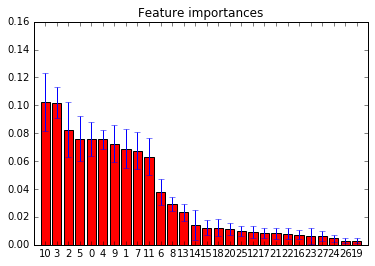

In [29]:
# plot the feature importances of the random forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0,0.16])
plt.show()

### Bonus part : Train with an increasing part of the datas :

In [32]:
number_splits = 8

train_errors =[]
test_errors = []
sizeOfDatas = range(number_splits,X.shape[0],int(X.shape[0]/15))

for sizeOfData in sizeOfDatas:
    kf = KFold(sizeOfData, n_folds=number_splits)
    mean_train_error = 0.0
    mean_test_error = 0.0
    
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf = RandomForestClassifier(n_estimators=10, criterion='entropy',max_depth = 15)
        clf = clf.fit(X_train, Y_train)
        
        train_error =1- clf.score(X_train, Y_train)
        test_error =1- clf.score(X_test, Y_test)
        
        mean_train_error += train_error
        mean_test_error += test_error
        
    train_errors.append(mean_train_error/number_splits)
    test_errors.append(mean_test_error/number_splits)

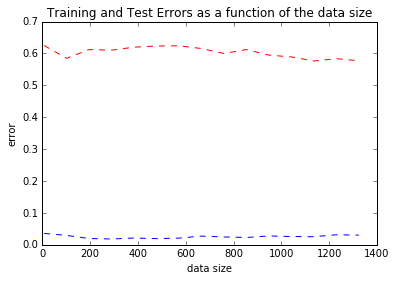

In [33]:
# plot
plt.plot(sizeOfDatas, test_errors, 'r--', sizeOfDatas, train_errors, 'b--')
plt.xlabel('data size')
plt.ylabel('error')
plt.title('Training and Test Errors as a function of the data size')
plt.show()

## Clustering

In [35]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

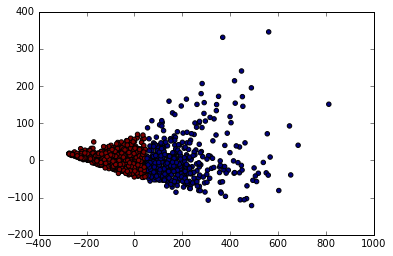

How well does it fit: 0.535838085832


In [37]:
kmean = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
kmean.fit(clean_data)
labels = kmean.labels_
kmean.cluster_centers_

pca = PCA(n_components = 2)

# Fit the Principal component analysis model on the numeric columns from earlier.
plot_columns = pca.fit_transform(clean_data)
# Make a scatter plot of each game according to previous cluster assignment.
plt.scatter(x = plot_columns[:,0], y = plot_columns[:,1], c = labels)
plt.show()

print('How well does it fit:', sklearn.metrics.silhouette_score(clean_data, kmean.labels_, metric='euclidean'))

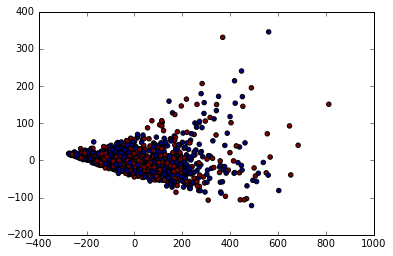

How well does it fit :  0.000440807223308


In [38]:
## Theoritical cluste, if we use Kmean in the array filled of 0, 1 for the color we have this ...

kmean = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
clean_data['color'] = clean_data['skin_cat'].apply(lambda x: 1 if x >= 0.5 else 0)

X_perfect = clean_data[['color']]
kmean.fit(X_perfect)
labels = kmean.labels_
kmean.cluster_centers_

pca = PCA(n_components = 2)

# Fit the Principal component analysis model on the numeric columns from earlier.
plot_columns = pca.fit_transform(clean_data)
# Make a scatter plot of each game according to previous cluster assignment.
plt.scatter(x = plot_columns[:,0], y = plot_columns[:,1], c = labels )
plt.show()
print('How well does it fit : ',sklearn.metrics.silhouette_score(clean_data, kmean.labels_, metric='euclidean'))

In [39]:
# matrice de variance covariance
clean_data.corr()

,height,weight,raterMean,defeats,meanIAT,yellowCards,games,redCards,ties,yellowReds,...,dummyCode__Defensive Midfielder,dummyCode__Goalkeeper,dummyCode__Left Fullback,dummyCode__Left Midfielder,dummyCode__Left Winger,dummyCode__Right Fullback,dummyCode__Right Midfielder,dummyCode__Right Winger,skin_cat,color
height,1.000000,0.797967,-0.076996,-0.028425,-0.113300,-0.105762,-0.044851,0.054081,-0.047313,-0.032954,...,-0.057743,0.385370,-0.122035,-0.178320,-0.102522,-0.099788,-0.162632,-0.135792,-0.070665,-0.124513
weight,0.797967,1.000000,-0.039400,0.027689,-0.063538,-0.026623,0.015776,0.080743,0.001852,0.025388,...,-0.081704,0.384470,-0.080031,-0.182949,-0.093142,-0.089145,-0.156246,-0.099781,-0.037373,-0.054224
raterMean,-0.076996,-0.039400,1.000000,-0.025717,-0.141697,-0.023170,-0.021323,0.046841,0.002557,0.019382,...,0.035279,-0.113353,0.008567,-0.011828,0.057794,0.013944,-0.023638,0.080488,0.993199,0.747958
defeats,-0.028425,0.027689,-0.025717,1.000000,-0.060826,0.561597,0.870539,0.329785,0.894097,0.230144,...,0.005097,-0.081660,-0.047444,0.065644,0.016857,-0.006729,0.020978,0.028180,-0.024615,0.017458
meanIAT,-0.113300,-0.063538,-0.141697,-0.060826,1.000000,0.149470,-0.017211,0.063739,-0.061022,0.153953,...,-0.021654,-0.063948,0.030695,0.011425,0.013977,0.000595,-0.029124,0.018183,-0.158652,0.011774
yellowCards,-0.105762,-0.026623,-0.023170,0.561597,0.149470,1.000000,0.651519,0.488544,0.620196,0.610698,...,0.209916,-0.320681,0.005628,-0.003727,-0.017795,0.092254,-0.015888,-0.033490,-0.030234,0.049452
games,-0.044851,0.015776,-0.021323,0.870539,-0.017211,0.651519,1.000000,0.362299,0.958518,0.273702,...,0.013893,-0.095433,-0.041384,0.017229,0.031266,0.005505,-0.002403,0.041701,-0.019799,0.021392
redCards,0.054081,0.080743,0.046841,0.329785,0.063739,0.488544,0.362299,1.000000,0.368454,0.361283,...,0.001871,-0.034280,-0.005567,-0.018122,-0.050997,-0.012266,-0.066370,0.000074,0.040869,0.076095
ties,-0.047313,0.001852,0.002557,0.894097,-0.061022,0.620196,0.958518,0.368454,1.000000,0.257369,...,0.021292,-0.084880,-0.039713,0.018250,0.030546,0.007949,0.008971,0.036003,0.005273,0.035569
yellowReds,-0.032954,0.025388,0.019382,0.230144,0.153953,0.610698,0.273702,0.361283,0.257369,1.000000,...,0.150294,-0.225204,0.011811,0.016970,-0.049998,0.082956,-0.018392,-0.058822,0.013337,0.047144
